# Import data


In this notebook, we look at import functions and how to assign data to the grid. 

---

We import the class: 

In [ ]:
#from grid import *

# or:

config_file = "../code/grid.py"
with open(config_file) as f:
    code = compile(f.read(), config_file, 'exec')
    exec(code, globals(), locals())

Now we make two grid objects, one of the Antarctic continent in  [EPSG:3031. WGS 84 / Antarctic Polar Stereographic projection](https://epsg.io/3031) and also a global model, using [WGS84](https://epsg.io/4326). Resolution is defined in the unit of the projection, meters for stereographic projection, and degrees for the global grid. The coordinates in the xarray dataset are stored as dask arrays, they are not loaded until they are needed. When processed, they are loaded as smaller chunks, 1/10 of the axes large. 

In [ ]:
#Continental
ant = Grid(res = [25*km, 25*km], left = -3100*km, up=3100*km, right = 3100*km, down = -3100*km)

print(ant.ds)

#Global (almost)
world = Grid(crs_tgt=4326, res = [1, 1], left = -180, up=90, right = 180, down = -90)

print(world.ds)

We download a raster, in this case the global 1:50m Bathymetry. It is 66Mb. 

In [ ]:
! mkdir -p ../../data/ne
! wget -nc https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/NE1_50M_SR.zip \
    -O ../../data/ne/NE1_50M_SR.zip
    
! unzip -n ../../data/ne/NE1_50M_SR.zip -d ../../data/ne

We import the raster to the global grid and to the Antarctic grid: 
The raster has three channels, so we assign it to X, Y and RGB coordinates. This might also take some time, as the raster needs to be warped to each grid. We can speed up a bit by subsampling the raster before warp. 

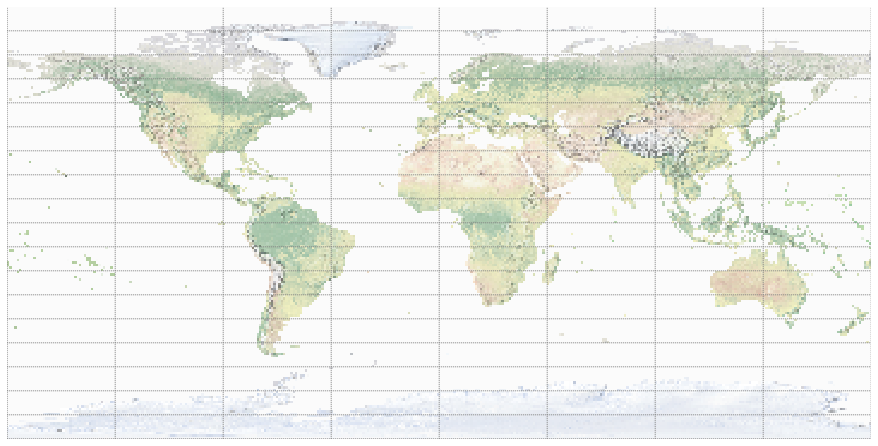

In [10]:
world.ds['RGB_RASTER'] = (('Y', 'X', 'RGB'), 
                world.read_raster('../../data/ne/NE1_50M_SR/NE1_50M_SR.tif', sub_sampling=5))

world.map_grid('RGB_RASTER', draw_coast=False)


1


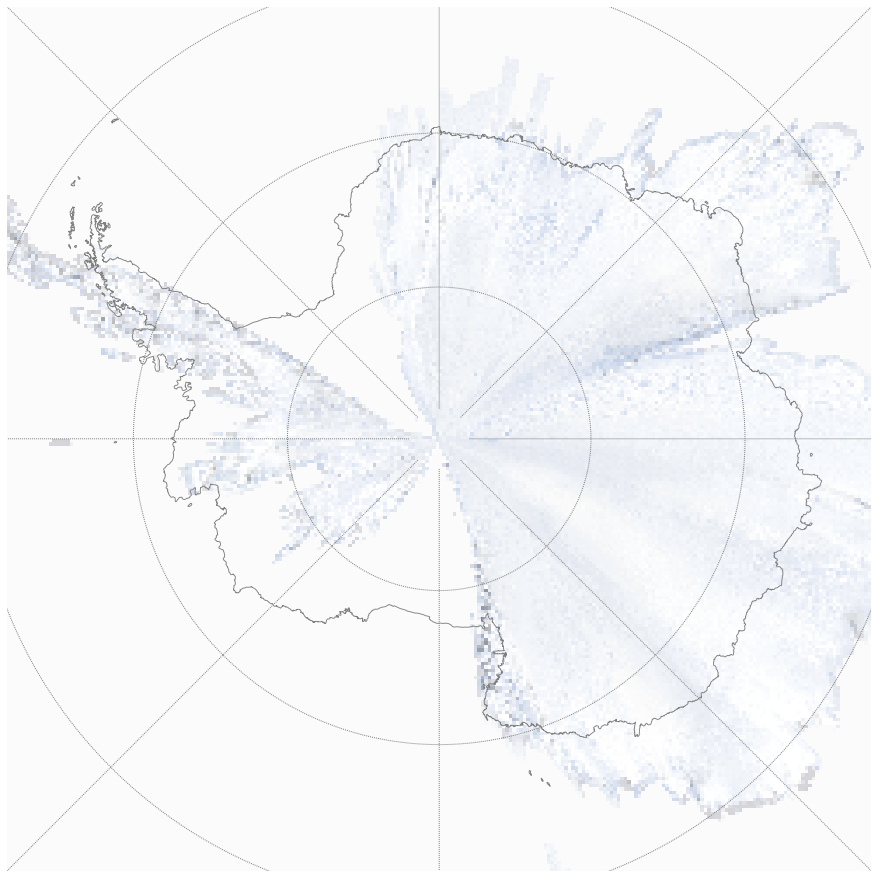

In [8]:
ant.ds['RGB_RASTER'] = (('Y', 'X', 'RGB'), 
                ant.read_raster('../../data/ne/NE1_50M_SR/NE1_50M_SR.tif', sub_window = ((3040, 5040),(0, 10800))))

ant.map_grid('RGB_RASTER')

Pretty, but the raison d'etre for this code is to work properly in 3D. We download AN-1S sesimic 3D model of the Antarctic lithosphere. 

In [ ]:
! mkdir -p ../../data/an
! wget -nc http://www.seismolab.org/model/antarctica/lithosphere/AN1-S_depth_grd.tar.gz \
    -O ../../data/an/AN1-S_depth_grd.tar.gz
! tar -xvzf ./../data/an/AN1-S_depth_grd.tar.gz -C ../../data/an

In [ ]:
import glob

an_files = sorted(glob.glob('../data/An/AN1-S_depth_grd/*.grd'))
ant.ds.coords['AN_Z'] = [np.float32(d[-9:-4])*km for d in an_files]
str_depths = [str(d[-9:-4]) for d in an_files]

for d in ('S', 'Tc', 'Ts'):
    print('\n',d)
    an_array = np.empty((ant.nx, ant.ny, len(an_files)))
    an_array[:] = np.nan
    for i, a in enumerate(ant.ds.coords['AN_Z'].values):
        print(a//km, end=' ')
        fname = '../data/An/AN1-%s_depth_grd/AN1-%s_hslice_%s.grd'%(d,d,str_depths[i])
        if os.path.isfile(fname):
            an_array[:,:,i] = ant.read_grid(fname, xyz = ('x','y','z') ) 
    
    ant.ds['AN_%s'%d] = (('X', 'Y', 'AN_Z'), an_array)


In [ ]:
ant.ds['AN_S'].isel(AN_Z=30)

In [ ]:
ant.ds['AN_S'].sel(AN_Z=200*km)

In [ ]:
ant.grid_to_raster(ant.ds['AN_S'].sel(AN_Z=200*km), '../../An_S_200km.tiff')

In [ ]:
! mkdir -p data/raster
! wget -nc https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/raster/GRAY_LR_SR_W.zip \
    -O data/raster/GRAY_LR_SR_W.zip
! unzip -n data/raster/GRAY_LR_SR_W.zip -d data/raster


## A detailed map

Now we try a high resolution dataset with a different projection. 

Again, we download some data, both raster and vector. Ref: [Norwegian Polar Institute 2014](https://data.npolar.no/dataset/19700322-beab-40e7-b867-c3f0c2756071)

Basemap is used to produce maps from the grid, it supports a [large range](https://matplotlib.org/basemap/users/mapsetup.html) of projections, but not all. [epsg 32731](https://epsg.io/32731) is not supported, but we can always use standard matplotlib or mayavi as the grid is regularly sampled. 

In [ ]:
#Make object
bouvet = Grid(crs_tgt=32731, res = [5, 5], 
             up = 3974168, 
             left=517217 , 
             down = 3965208, 
             right = 529277)

print(bouvet.ds)

In [ ]:
! mkdir -p ../../data/bouvet

! wget -nc https://publicdatasets.data.npolar.no/kartdata/NP_B0_DTM20.zip \
    -O ../../data/bouvet/NP_B0_DTM20.zip 
! unzip -n ../../data/bouvet/NP_B0_DTM20.zip -d ../../data/bouvet

! wget -nc https://publicdatasets.data.npolar.no/kartdata/NP_B20_SHP.zip \
    -O ../../data/bouvet/NP_B20_SHP.zip
! unzip -n ../../data/bouvet/NP_B20_SHP.zip -d ../../data/bouvet

! wget -nc https://content.satimagingcorp.com/static/galleryimages/landsat%208%20bouvet%20island%20lg.jpg \
    -O ../../data/bouvet/landsat_bouvet.jpg

In [ ]:
bouvet.ds['DEM'] = (('Y', 'X'), 
                bouvet.read_raster('../../data/bouvet/NP_B0_DTM20/B0_DTM20.tif'))



In [ ]:
bouvet.ds['LAND'] = (('Y', 'X'), 
                     bouvet.assign_shape('../../data/bouvet/NP_B20_SHP/B20_Land_f.shp', None, burn_val=1) )

In [ ]:
plt.imshow(bouvet.ds['LAND'].values)
plt.show()

plt.imshow(bouvet.ds['DEM'].values)
plt.show()
bouvet.ds['DEM'][:,1222]